In [1]:
#Pytorch 
import numpy as np
import torch
import gpytorch
import botorch 

import matplotlib.pyplot as plt

# BO for Minimizing Emittance*Bmag with 9 Variables (SQ, CQ, SOL, matching quads)

## Gaussian Regression & Acquisition Function

In [2]:
def get_BO_point(x, f, bounds = None, beta=2.5, mean_module=None, input_transform=None, outcome_transform=None, precision = None, phys=False):
    """
    function that trains a GP model of data and returns the next observation point using UCB
    D is input space dimensionality
    N is number of samples

    :param x: input points data, torch.tensor, shape (N,D)
    :param f: output point data, torch.tensor, shape (N,1)
    :param bounds: input space bounds, torch.tensor, shape (2,D)
    :param precision: precision matrix used for RBF kernel (must be PSD), torch.tensor, (D,D)
    :param beta: UCB optimization parameter, float
    :return x_candidate, model: next observation point and gp model w/observations
    """
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
 
    gp = botorch.models.SingleTaskGP(x, f)
    gp.mean_module.constant.data = torch.tensor(1.0)
    gp.likelihood.noise_covar.noise = torch.tensor(1e-4)
        
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    
#     #fit GP hyperparameters
    #botorch.fit.fit_gpytorch_model(mll)

#     #do UCB acquisition
    # UCB = botorch.acquisition.UpperConfidenceBound(gp, beta=beta)
    # candidate, acq_value = botorch.optim.optimize_acqf(UCB,
    #                                                    bounds=bounds,
    #                                                    q=1,
    #                                                    num_restarts=20,
    #                                                    raw_samples=20)
    return gp

## Set up initial training samples

In [3]:
train_x = torch.tensor([[0.5],[1.0]]).reshape(-1,1)
train_y = torch.tensor([[5.0],[4.0]]).reshape(-1,1)

transformer_x = botorch.models.transforms.input.Normalize(1)
transformer_y = botorch.models.transforms.outcome.Standardize(1)

In [4]:
from gpytorch.means.mean import Mean
class MeanSquared(Mean):
    def __init__(self, input_transform, outcome_transform):
        super(MeanSquared, self).__init__()
        self.input_transform = input_transform 
        self.outcome_transform = outcome_transform
        
    def forward(self, x):
        self.input_transform.eval()
        self.outcome_transform.eval()
        #print(x)
        x = self.input_transform.untransform(x) # normed x -> real x 
        #print(x)
        out = 0.1*(x.squeeze(-1)**2) # real x |-> real y 
        out = self.outcome_transform(out)[0] # real y -> standardized y
        
        self.input_transform.eval() 
        self.outcome_transform.train()
        return out

## Bayesian Optimization

In [1]:
model = botorch.models.SingleTaskGP(train_x, 
                                    train_y, 
                                    mean_module=MeanSquared(transformer_x, transformer_y),
                                    input_transform=transformer_x,
                                    outcome_transform=transformer_y)
model.likelihood.noise_covar.noise = torch.tensor(1e-4)

NameError: name 'botorch' is not defined

In [6]:
# constant prior mean
# constant_prior_best_y = BayesianOptimization(train_x, train_y, 30, prior = None, phys = False) 

### use NN as prior mean

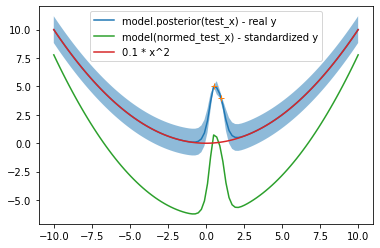

In [7]:
test_x = torch.linspace(-10,10,100).reshape(-1,1).unsqueeze(0)
#print(test_x)
model.eval()
with torch.no_grad():
    real_post = model.posterior(test_x)
    std_post = model(transformer_x(test_x))
    real_mean = real_post.mean
    std_mean = std_post.mean
    lower,upper = real_post.mvn.confidence_region()

back_to_real = transformer_y.untransform(std_mean.reshape(-1,1))[0]
fig,ax = plt.subplots()
ax.plot(test_x.flatten(), real_mean.flatten(), label = "model.posterior(test_x) - real y")
ax.plot(train_x, train_y, "+")
ax.plot(test_x.flatten(), std_mean.flatten(), label = "model(normed_test_x) - standardized y")
ax.plot(test_x.flatten(), 0.1 * test_x.flatten().pow(2), label = "0.1 * x^2")

ax.fill_between(test_x.flatten(),lower.flatten(),upper.flatten(),alpha = 0.5)
ax.legend()

In [8]:
x = torch.zeros((100,9))

In [ ]:
x[:,0] = torch.linspace(0,1,100)
x[:,1] = 1.0
x

In [10]:
"""
#define acquisition function
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

#optimize
n_steps = 45
for i in range(n_steps):
    #best_normed_y = torch.max(normed_train_y)
    UCB = UpperConfidenceBound(gp, beta=2.5)
    #EI = ExpectedImprovement(gp, best_normed_y)

    bounds = torch.cat((torch.zeros(1,3), torch.ones(1,3)), 0)
    candidate, acq_value = optimize_acqf(UCB, bounds = bounds, num_restarts = 20, q = 1, raw_samples = 20)

    train_x = torch.cat((train_x, transformer_x.backward(candidate)))
    normed_train_x = transformer_x.forward(train_x)

    new_y = torch.tensor(evaluate(train_x[-1][0], train_x[-1][1], train_x[-1][2])).reshape(1,1)
    train_y = torch.cat((train_y, new_y))
    
    print("iteration        target         varx         vary         varz")
    print(f'{i+1}              {train_y[-1][0]:.5f}      {train_x[-1][0]:.5f}      {train_x[-1][1]:.5f}      {train_x[-1][2]:.5f}')
    print(torch.max(train_y))
    
    transformer_y = transformer.Transformer(train_y, 'standardize')
    normed_train_y = transformer_y.forward(train_y)

    gp = SingleTaskGP(normed_train_x, normed_train_y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll);
"""

'\n#define acquisition function\nfrom botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement\nfrom botorch.optim import optimize_acqf\n\n#optimize\nn_steps = 45\nfor i in range(n_steps):\n    #best_normed_y = torch.max(normed_train_y)\n    UCB = UpperConfidenceBound(gp, beta=2.5)\n    #EI = ExpectedImprovement(gp, best_normed_y)\n\n    bounds = torch.cat((torch.zeros(1,3), torch.ones(1,3)), 0)\n    candidate, acq_value = optimize_acqf(UCB, bounds = bounds, num_restarts = 20, q = 1, raw_samples = 20)\n\n    train_x = torch.cat((train_x, transformer_x.backward(candidate)))\n    normed_train_x = transformer_x.forward(train_x)\n\n    new_y = torch.tensor(evaluate(train_x[-1][0], train_x[-1][1], train_x[-1][2])).reshape(1,1)\n    train_y = torch.cat((train_y, new_y))\n    \n    print("iteration        target         varx         vary         varz")\n    print(f\'{i+1}              {train_y[-1][0]:.5f}      {train_x[-1][0]:.5f}      {train_x[-1][1]:.5f}      {train_x[-